# Predict tags on StackOverflow with linear models

We will learn how to predict tags for posts from [StackOverflow](https://stackoverflow.com). To solve this task you will use multilabel classification approach.

### Libraries

In this task you will need the following libraries:
- [Numpy](http://www.numpy.org) — a package for scientific computing.
- [Pandas](https://pandas.pydata.org) — a library providing high-performance, easy-to-use data structures and data analysis tools for the Python
- [scikit-learn](http://scikit-learn.org/stable/index.html) — a tool for data mining and data analysis.
- [NLTK](http://www.nltk.org) — a platform to work with natural language.
- [Maplotlib](https://github.com/matplotlib/matplotlib) - Matplotlib is a python library used to create 2D graphs and plots by using python scripts.

In [67]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

#### Data preprocessing

In this task we will deal with a dataset of post titles from StackOverflow. Datasets is splited into 3 sets: *train*, *validation* and *test*. All corpora (except for *test*) contain titles of the posts and corresponding tags (100 tags are available). By running the next cell you will first download the datasets.

In [68]:


import workshop
workshop.download_tag_prediction()
DATA_DIR='tag-prediction'

File tag-prediction/train.tsv is already downloaded.
File tag-prediction/validation.tsv is already downloaded.
File tag-prediction/test.tsv is already downloaded.
File tag-prediction/text_prepare_tests.tsv is already downloaded.


Lets download the Python packages now...

In [69]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [70]:
from ast import literal_eval
import pandas as pd
import numpy as np

In [71]:
#Creating a function using panda to read CSV data where tab is the separator. Feel free to take a look at the data yourself
def read_data(filename):
    data = pd.read_csv(filename, sep='\t')
    data['tags'] = data['tags'].apply(literal_eval)
    return data


In [72]:
#Reading the train/validation/test data
train = read_data(DATA_DIR+'/train.tsv')
validation = read_data(DATA_DIR+'/validation.tsv')
test = pd.read_csv(DATA_DIR+'/test.tsv', sep='\t')


In [73]:
#Lets take a look at some of the initial questions in the training data set
train.head()

,title,tags
0,How to draw a stacked dotplot in R?,[r]
1,mysql select all records where a datetime fiel...,"[php, mysql]"
2,How to terminate windows phone 8.1 app,[c#]
3,get current time in a specific country via jquery,"[javascript, jquery]"
4,Configuring Tomcat to Use SSL,[java]


In [74]:
# Lets split the title and tags into different lists for easier analysis as there can be multiple tags for a title

X_train, y_train = train['title'].values, train['tags'].values
X_val, y_val = validation['title'].values, validation['tags'].values
X_test = test['title'].values


In [25]:
y_train

array([list(['r']), list(['php', 'mysql']), list(['c#']), ...,
       list(['python', 'datetime', 'pandas']),
       list(['javascript', 'jquery']), list(['java', 'list', 'generics'])],
      dtype=object)

natural data is unstructured and can have special characters making it harder to tokenize. For example, if you use it "as is" and extract tokens just by splitting the titles by whitespaces, you will see that there are many "weird" tokens like *3.5?*,  etc. To prevent the problems, it's usually sanitized

In [75]:
import re
from nltk.corpus import stopwords

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def text_prepare(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = re.sub('[/(){}\[\]\|@,;]',' ', text)# replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub('[^0-9a-z #+_]', '', text)# delete symbols which are in BAD_SYMBOLS_RE from text
    text = [word for word in text.split(' ') if len(word) > 0 and word not in STOPWORDS]
    return ' '.join(text)


In [76]:

def test_text_prepare():
    examples = ["SQL Server - any equivalent of Excel's CHOOSE function?",
                "How to free c++ memory vector<int> * arr?"]
    answers = ["sql server equivalent excels choose function", 
               "free c++ memory vectorint arr"]
    for ex, ans in zip(examples, answers):
        if text_prepare(ex) != ans:
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'


In [37]:

print(test_text_prepare())


Basic tests are passed.


In [77]:

prepared_questions = []
for line in open(DATA_DIR+'/text_prepare_tests.tsv', encoding='utf-8'):
    line = text_prepare(line.strip())
    prepared_questions.append(line)
text_prepare_results = '\n'.join(prepared_questions)


Now we can preprocess the titles using function *text_prepare* and  making sure that the headers don't have bad symbols:

In [78]:

X_train = [text_prepare(x) for x in X_train]
X_val = [text_prepare(x) for x in X_val]
X_test = [text_prepare(x) for x in X_test]


In [79]:
X_train[:3]

['draw stacked dotplot r',
 'mysql select records datetime field less specified value',
 'terminate windows phone 81 app']

For each tag and for each word calculate how many times they occur in the train corpus. 

In [80]:

# Dictionary of all tags from train corpus with their counts.
tags_counts = {}
# Dictionary of all words from train corpus with their counts.
words_counts = {}


for txt in X_train:
    for word in txt.split(' '):
        if word not in words_counts:
            words_counts[word] = 0
        words_counts[word] += 1
        
for tags in y_train:
    for tag in tags:
        if tag not in tags_counts:
            tags_counts[tag] = 0
        tags_counts[tag] += 1
        


In [81]:

most_common_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)[:3]
most_common_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:3]

print(most_common_tags)
print(most_common_words)


[('javascript', 19078), ('c#', 19077), ('java', 18661)]
[('using', 8278), ('php', 5614), ('java', 5501)]


### Transforming text to a vector

Machine Learning algorithms work with numeric data and we cannot use the provided text data "as is". There are many ways to transform text data to numeric vectors. In this task you will try to use two of them.

#### Bag of words

One of the well-known approaches is a *bag-of-words* representation. To create this transformation, follow the steps:
1. Find *N* most popular words in train corpus and numerate them. Now we have a dictionary of the most popular words.
2. For each title in the corpora create a zero vector with the dimension equals to *N*.
3. For each text in the corpora iterate over words which are in the dictionary and increase by 1 the corresponding coordinate.

Let's try to do it for a toy example. Imagine that we have *N* = 4 and the list of the most popular words is 

    ['hi', 'you', 'me', 'are']

Then we need to numerate them, for example, like this: 

    {'hi': 0, 'you': 1, 'me': 2, 'are': 3}

And we have the text, which we want to transform to the vector:

    'hi how are you'

For this text we create a corresponding zero vector 

    [0, 0, 0, 0]
    
And iterate over all words, and if the word is in the dictionary, we increase the value of the corresponding position in the vector:

    'hi':  [1, 0, 0, 0]
    'how': [1, 0, 0, 0] # word 'how' is not in our dictionary
    'are': [1, 0, 0, 1]
    'you': [1, 1, 0, 1]

The resulting vector will be 

    [1, 1, 0, 1]
   
Described encoding in the function *my_bag_of_words* with the size of the dictionary equals to 5000. To find the most common words use train data.

In [82]:
DICT_SIZE = 5000
sorted_tags = sorted(tags_counts.items(), key=lambda x: x[1], reverse=True)
sorted_words = sorted(words_counts.items(), key=lambda x: x[1], reverse=True)[:DICT_SIZE]

WORDS_TO_INDEX = dict([(pair[0],idx) for idx, pair in enumerate(sorted_words)])
INDEX_TO_WORDS = dict([(idx,word) for word,idx in WORDS_TO_INDEX.items()])
ALL_WORDS = WORDS_TO_INDEX.keys()

def my_bag_of_words(text, words_to_index, dict_size):
    """
        text: a string
        dict_size: size of the dictionary
        
        return a vector which is a bag-of-words representation of 'text'
    """
    result_vector = np.zeros(dict_size)
    for word in text.split(' '):
        if word not in words_to_index:
            continue;
        result_vector[words_to_index[word]] += 1
    return result_vector

In [83]:
def test_my_bag_of_words():
    words_to_index = {'hi': 0, 'you': 1, 'me': 2, 'are': 3}
    examples = ['hi how are you']
    answers = [[1, 1, 0, 1]]
    for ex, ans in zip(examples, answers):
        if (my_bag_of_words(ex, words_to_index, 4) != ans).any():
            return "Wrong answer for the case: '%s'" % ex
    return 'Basic tests are passed.'

In [84]:
print(test_my_bag_of_words())

Basic tests are passed.


#### Using Sparce matrices
By definition, a sparse matrix is called "sparse" if most of its elements are zero. In the bag of words model, each document is represented as a word-count vector. These counts can be binary counts (does a word occur or not) or absolute counts (term frequencies, or normalized counts), and the size of this vector is equal to the number of elements in your vocabulary. Now lets apply the above implemented function to all samples: 

we transform the data to sparse representation, to store the useful information efficiently. There are many [types](https://docs.scipy.org/doc/scipy/reference/sparse.html) of such representations, however sklearn algorithms can work only with [csr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html#scipy.sparse.csr_matrix) matrix, so we will use this one.

In [86]:
from scipy import sparse as sp_sparse
X_train_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_train])
X_val_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_val])
X_test_mybag = sp_sparse.vstack([sp_sparse.csr_matrix(my_bag_of_words(text, WORDS_TO_INDEX, DICT_SIZE)) for text in X_test])
print('X_train shape ', X_train_mybag.shape)
print('X_val shape ', X_val_mybag.shape)
print('X_test shape ', X_test_mybag.shape)


X_train shape  (100000, 5000)
X_val shape  (30000, 5000)
X_test shape  (20000, 5000)


In [88]:

row = X_train_mybag[10].toarray()[0]
non_zero_elements_count = [val for val in row if val!=0]
print(len(non_zero_elements_count))


7


# ADD CONCLUSION

#### TF-IDF

The second approach extends the bag-of-words framework by taking into account total frequencies of words in the corpora. It helps to penalize too frequent words and provide better features space. 

Function *tfidf_features* using class [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) from *scikit-learn*. Using *train* corpus to train a vectorizer.

An introduction to TF-IDF
TF-IDF stands for “Term Frequency — Inverse Data Frequency”. First, we will learn what this term means mathematically.

Term Frequency (tf): gives us the frequency of the word in each document in the corpus. It is the ratio of number of times the word appears in a document compared to the total number of words in that document. It increases as the number of occurrences of that word within the document increases. Each document has its own tf.

![title](tf.png)

Inverse Data Frequency (idf): used to calculate the weight of rare words across all documents in the corpus. The words that occur rarely in the corpus have a high IDF score. It is given by the equation below.

![title](idf.png)

Combining these two we come up with the TF-IDF score (w) for a word in a document in the corpus. It is the product of tf and idf:



Let’s take an example to get a clearer understanding.

Sentence 1 : The car is driven on the road.

Sentence 2: The truck is driven on the highway.

In this example, each sentence is a separate document.

We will now calculate the TF-IDF for the above two documents, which represent our corpus.
![title](tf-idf-matrices.png)


From the above table, we can see that TF-IDF of common words was zero, which shows they are not significant. On the other hand, the TF-IDF of “car” , “truck”, “road”, and “highway” are non-zero. These words have more significance.

In [50]:

from sklearn.feature_extraction.text import TfidfVectorizer

def tfidf_features(X_train, X_val, X_test):
    """
        X_train, X_val, X_test — samples        
        return TF-IDF vectorized representation of each sample and vocabulary
    """
    # Create TF-IDF vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test, and val sets and return the result
    
    
    tfidf_vectorizer = TfidfVectorizer(analyzer='word', stop_words=STOPWORDS, token_pattern = '(\S+)', 
                                       ngram_range=(1,2), max_df = 0.9, min_df = 5)
    
    X_train = tfidf_vectorizer.fit_transform(X_train)
    
    X_test = tfidf_vectorizer.transform(X_test)
    
    X_val = tfidf_vectorizer.transform(X_val)
    
    return X_train, X_val, X_test, tfidf_vectorizer.vocabulary_


Let's fit the vectorizer on the training dataset

In [51]:

tfidf_vectorizer = TfidfVectorizer(stop_words=STOPWORDS, ngram_range=(1,2), max_df = 0.9, min_df = 5)

tfidf_vectorizer.fit_transform(X_train)


<100000x17778 sparse matrix of type '<class 'numpy.float64'>'
	with 653252 stored elements in Compressed Sparse Row format>

Transform the train, test, and validation data sets and return the result

In [90]:

X_train_tfidf, X_val_tfidf, X_test_tfidf, tfidf_vocab = tfidf_features(X_train, X_val, X_test)
tfidf_reversed_vocab = {i:word for word,i in tfidf_vocab.items()}


Lets check whether you have sql in your vocabulary, as it is an important token in our tags prediction task. Feel free to check for other words that don't exist in our data, you are likely going to get a Key Error.

In [89]:
tfidf_vocab['sql']

14869

# Need to add conclusion - take away point

### MultiLabel classifier

We have noticed before, in this task each example can have multiple tags. To deal with such kind of prediction, we need to transform labels in a binary form and the prediction will be a mask of 0s and 1s. For this purpose it is convenient to use [MultiLabelBinarizer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MultiLabelBinarizer.html) from *sklearn*.

In [91]:

from sklearn.preprocessing import MultiLabelBinarizer


In [92]:

mlb = MultiLabelBinarizer(classes=sorted(tags_counts.keys()))
y_train_b = mlb.fit_transform(y_train)
y_val_b = mlb.fit_transform(y_val)


Function *train_classifier* for training a classifier.We use One-vs-Rest approach, which is implemented in [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) class. In this approach *k* classifiers (= number of tags) are trained. As a basic classifier, use [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). It is one of the simplest methods, but often it performs good enough in text classification tasks. It might take some time, because a number of classifiers to train is large.

In [94]:

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier

def train_classifier(X_train, y_train):
    """
      X_train, y_train — training data
      
      return: trained classifier
    """
        
    clf = OneVsRestClassifier(LogisticRegression(), -1)
    
    clf.fit(X_train, y_train)
    
    return clf
    
    


Training the classifiers for different data transformations: *bag-of-words* and *tf-idf*.

In [95]:

classifier_mybag = train_classifier(X_train_mybag, y_train_b)
classifier_tfidf = train_classifier(X_train_tfidf, y_train_b)


Now you can create predictions for the data. You will need two types of predictions: labels and scores.

In [100]:

y_val_predicted_labels_mybag = classifier_mybag.predict(X_val_mybag)
y_val_predicted_scores_mybag = classifier_mybag.decision_function(X_val_mybag)

y_val_predicted_labels_tfidf = classifier_tfidf.predict(X_val_tfidf)
y_val_predicted_scores_tfidf = classifier_tfidf.decision_function(X_val_tfidf)


Now take a look at how classifier, which uses TF-IDF. You'd see that it works for a few examples:

In [99]:

y_val_pred_inversed = mlb.inverse_transform(y_val_predicted_labels_mybag)
y_val_inversed = mlb.inverse_transform(y_val_b)
for i in range(10):
    print('Title:\t{}\nTrue labels:\t{}\nPredicted labels:\t{}\n\n'.format(
        X_val[i],
        ','.join(y_val_inversed[i]),
        ','.join(y_val_pred_inversed[i])
    ))


Title:	odbc_exec always fail
True labels:	php,sql
Predicted labels:	


Title:	access base classes variable within child class
True labels:	javascript
Predicted labels:	


Title:	contenttype application json required rails
True labels:	ruby,ruby-on-rails
Predicted labels:	ruby-on-rails


Title:	sessions sinatra used pass variable
True labels:	ruby,session
Predicted labels:	ruby


Title:	getting error type json exist postgresql rake db migrate
True labels:	json,ruby,ruby-on-rails
Predicted labels:	json,ruby-on-rails


Title:	library found
True labels:	c++,ios,iphone,xcode
Predicted labels:	


Title:	csproj file programmatic adding deleting files
True labels:	c#
Predicted labels:	


Title:	typeerror makedirs got unexpected keyword argument exists_ok
True labels:	django,python
Predicted labels:	python


Title:	pan div using jquery
True labels:	html,javascript,jquery
Predicted labels:	javascript,jquery


Title:	hibernate intermediate advanced tutorials
True labels:	hibernate,java
Predicted 

Now, we would need to compare the results of different predictions, e.g. to see whether TF-IDF transformation helps or to try different regularization techniques in logistic regression. For all these experiments, we need to setup evaluation procedure. 

### Evaluation

To evaluate the results we will use several classification metrics:
 - [Accuracy](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)
 - [F1-score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
 - [Area under ROC-curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)
 - [Area under precision-recall curve](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score) 
 
Make sure you are familiar with all of them. How would you expect the things work for the multi-label scenario? Read about micro/macro/weighted averaging following the sklearn links provided above.

In [101]:

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score


Implement the function *print_evaluation_scores* which calculates and prints to stdout:
 - *accuracy*
 - *F1-score macro/micro/weighted*
 - *Precision macro/micro/weighted*

In [102]:

def print_evaluation_scores(y_val, predicted):
    
    acc = accuracy_score(y_val, predicted)
    
    micro_f1 = f1_score(y_val, predicted, average = 'micro')
    macro_f1 = f1_score(y_val, predicted, average = 'macro')
    weighted_f1 = f1_score(y_val, predicted, average = 'weighted')
    
    micro_prec = average_precision_score(y_val, predicted, average = 'micro')
    macro_prec = average_precision_score(y_val, predicted, average = 'macro')
    weighted_prec = average_precision_score(y_val, predicted, average = 'weighted')

    print('Accuracy: ', acc)
    print('F1 micro: ', micro_f1)
    print('F1 macro: ', macro_f1)
    print('F1 weighted: ', weighted_f1)
    
    print('Avg Precision micro: ', micro_prec)
    print('Avg Precision macro: ', macro_prec)
    print('Avg Precision weighted: ', weighted_prec)
    
    


In [104]:

print('Bag-of-words')
print_evaluation_scores(y_val_b, y_val_predicted_labels_mybag)
print('Tfidf')
print_evaluation_scores(y_val_b, y_val_predicted_labels_tfidf)


Bag-of-words
Accuracy:  0.35796666666666666
F1 micro:  0.6710820449370445
F1 macro:  0.5047313354605416
F1 weighted:  0.6486956090682869
Avg Precision micro:  0.4812849070834009
Avg Precision macro:  0.3445861908900063
Avg Precision weighted:  0.5108501640215136
Tfidf
Accuracy:  0.3339666666666667
F1 micro:  0.6418233967551946
F1 macro:  0.4457174836530887
F1 weighted:  0.6143691746843032
Avg Precision micro:  0.4570020540292232
Avg Precision macro:  0.3020388160757677
Avg Precision weighted:  0.4851137934615345


You might also want to plot some generalization of the [ROC curve](http://scikit-learn.org/stable/modules/model_evaluation.html#receiver-operating-characteristic-roc) for the case of multi-label classification. Provided function *roc_auc* can make it for you. The input parameters of this function are:
 - true labels
 - decision functions scores
 - number of classes

In [105]:
from metrics import roc_auc
%matplotlib inline


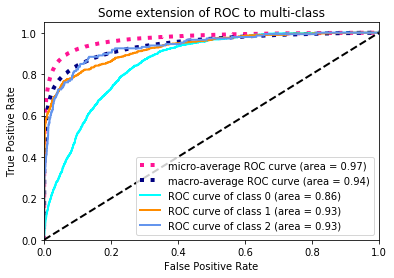

In [106]:

n_classes = len(tags_counts)
roc_auc(y_val_b, y_val_predicted_scores_mybag, n_classes)


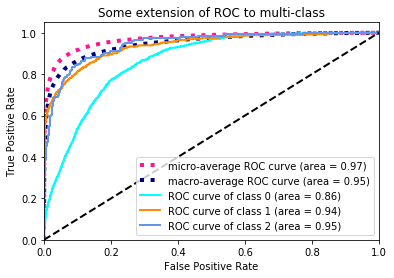

In [107]:

n_classes = len(tags_counts)
roc_auc(y_val_b, y_val_predicted_scores_tfidf, n_classes)


Finally, it is usually a good idea to look at the features (words or n-grams) that are used with the largest weigths in your logistic regression model.

Function *print_words_for_tag* to find them. Get back to sklearn documentation on [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html) and [LogisticRegression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if needed.

In [108]:

def print_words_for_tag(classifier, tag, tags_classes, index_to_words, all_words):
    """
        classifier: trained classifier
        tag: particular tag
        tags_classes: a list of classes names from MultiLabelBinarizer
        index_to_words: index_to_words transformation
        all_words: all words in the dictionary
        
        return nothing, just print top 5 positive and top 5 negative words for current tag
    """
    print('Tag:\t{}'.format(tag))
    
    # Extract an estimator from the classifier for the given tag.
    # Extract feature coefficients from the estimator. 
        
    idx = tags_classes.index(tag)
    coef = classifier_tfidf.coef_[idx]
    cd = {i:coef[i] for i in range(len(coef))}
    scd=sorted(cd.items(), key=lambda x: x[1], reverse=True)
    
    top_positive_words = [index_to_words[k[0]] for k in scd[:5]] # top-5 words sorted by the coefficiens.
    top_negative_words = [index_to_words[k[0]] for k in scd[-5:]] # bottom-5 words  sorted by the coefficients.
    print('Top positive words:\t{}'.format(', '.join(top_positive_words)))
    print('Top negative words:\t{}\n'.format(', '.join(top_negative_words)))


In [115]:

print_words_for_tag(classifier_tfidf, 'python', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'c++', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)
print_words_for_tag(classifier_tfidf, 'sql', mlb.classes, tfidf_reversed_vocab, ALL_WORDS)


Tag:	python
Top positive words:	python, pandas, numpy, matplotlib, flask
Top negative words:	jquery, javascript, c#, java, php

Tag:	c++
Top positive words:	c++, qt, boost, mfc, opencv
Top negative words:	c#, javascript, python, php, java

Tag:	sql
Top positive words:	sql, database, query, mysql, join
Top negative words:	c++, python, jquery, linq sql, javascript

